In [1]:
import matplotlib.pyplot as plt

# Flattened NFW halo
logM, Rs, q = 12.0, 25.0, 1.0
dirx, diry, dirz = 0., 0., 1. #1.0, 1.0, 1.0

# Plummer Sattelite
logm, rs = 8.0, 2.0 

# Initial conditions
x0, y0, z0 = 100.0, 0.0, 0.0     # Position in kpc
vx0, vy0, vz0 = 0.0, 200.0, 0.0  # Velocity in kpc/Gyr

# Integration time
time = 4. # Gyr
alpha = 1.0

params = (logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha)

### Agama Spray

In [4]:
import agama, numpy, matplotlib, matplotlib.pyplot as plt, time
from spray_agama import *
%matplotlib inline
numpy.set_printoptions(precision=6, linewidth=999, suppress=True)
numpy.random.seed(111)
plt.rc('font', size=12)
plt.rc('figure', dpi=75)
plt.rc('mathtext', fontset='stix')
# all dimensional quantities are given in the units of 1 kpc, 1 km/s, 1 Msun;
agama.setUnits(length=1, velocity=1, mass=1)
timeUnitGyr = agama.getUnits()['time'] / 1e3  # time unit is 1 kpc / (1 km/s)
print('time unit: %.3f Gyr' % timeUnitGyr)

time unit: 0.978 Gyr


In [5]:
# Flattened NFW halo
logM, Rs, q = 12.0, 25.0, 1.0
dirx, diry, dirz = 0., 0., 1. #1.0, 1.0, 1.0

# Plummer Sattelite
logm, rs = 8.0, 2.0 

# Initial conditions
x0, y0, z0 = 100.0, 0.0, 0.0     # Position in kpc
vx0, vy0, vz0 = 0.0, 200.0, 0.0  # Velocity in kpc/Gyr

# Integration time
time = 4. # Gyr
alpha = 1.0

params = (logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha)

n_steps = 500 # Number of steps in the time integration
n_particles = 10000 # Number of particles in the stream

In [8]:
posvel_sat = numpy.array([x0, y0, z0, vx0, vy0, vz0])

# fiducial potential of the Milky Way, consisting of a disk and a spherical halo
pot_host = agama.Potential(type='NFW', mass=10**logM, scaleRadius=Rs)

mass_sat   = 2.5e4  # in Msun
radius_sat = 0.004  # in kpc
time_total = 4.0    # in time units (0.978 Gyr)
num_particles = int(1e4)  # number of particles in the stream

xv_stream = create_stream_particle_spray(time_total, num_particles, pot_host, posvel_sat, mass_sat)

AttributeError: 'agama.Potential' object has no attribute 'eval'

In [9]:
# sky coordinates in degrees, distance in kpc, proper motion in mas/yr, heliocentric line-of-sight velocity in km/s
ra0, dec0 = 229.0, -0.124
dist0 = 22.9
pmra0, pmdec0 = -2.296, -2.257
vlos0 = -58.7

# use built-in coordinate conversion routines from Agama instead of Astropy: faster, no external dependencies,
# but need to do some extra steps, e.g., convert from degrees to radians and
# from mas/yr to km/s/kpc, the base units used throughout this example (the factor 4.74 below)
l0, b0, pml0, pmb0 = agama.transformCelestialCoords(agama.fromICRStoGalactic,
    ra0*numpy.pi/180, dec0*numpy.pi/180, pmra0, pmdec0)
posvel_sat = agama.getGalactocentricFromGalactic(l0, b0, dist0, pml0*4.74, pmb0*4.74, vlos0)

# Rotation matrix for conversion from ICRS to the Pal5 stream coordinate system (taken from Gala)
fromICRStoPal5 = numpy.array([
    [-0.65582036, -0.75491389, -0.00216422],
    [-0.62865701,  0.54771927, -0.55208149],
    [ 0.41795937, -0.36070573, -0.83378735],
])

# fiducial potential of the Milky Way, consisting of a disk and a spherical halo
pot_host = agama.Potential(
    dict(type='MiyamotoNagai', mass=6e10, scaleRadius=3.5, scaleHeight=0.28),
    dict(type='NFW', mass=1e12, scaleRadius=20)
)

mass_sat   = 2.5e4  # in Msun
radius_sat = 0.004  # in kpc
time_total = 4.0    # in time units (0.978 Gyr)
num_particles = int(1e4)  # number of particles in the stream

xv_stream = create_stream_particle_spray(time_total, num_particles, pot_host, posvel_sat, mass_sat)

# same coordinate conversion steps in reverse; also convert to stream coordinates (phi1 along, phi2 across)
def get_observed_coords(xv):
    l, b, dist, pml, pmb, vlos = agama.getGalacticFromGalactocentric(*xv.T)
    ra, dec = agama.transformCelestialCoords(agama.fromGalactictoICRS, l, b)
    phi1, phi2 = agama.transformCelestialCoords(fromICRStoPal5, ra, dec)
    return ra * 180/numpy.pi + 360, dec * 180/numpy.pi, vlos, phi1 * 180/numpy.pi, phi2 * 180/numpy.pi

ra, dec, vlos, phi1, phi2 = get_observed_coords(xv_stream)
ax = plt.subplots(1, 3, figsize=(12,4))[1]
ax[0].plot(ra, dec, 'bo', ms=1, mew=0)
ax[0].set_xlim(250, 220)
ax[0].set_ylim(-15, 15)
ax[0].set_aspect('equal')
ax[0].set_xlabel(r'$\alpha$ [deg]')
ax[0].set_ylabel(r'$\delta$ [deg]')
ax[1].plot(ra, vlos, 'bo', ms=1, mew=0)
ax[1].set_xlim(250, 220)
ax[1].set_ylim(-100, 0)
ax[1].set_xlabel(r'$\alpha$ [deg]')
ax[1].set_ylabel(r'$v_{\rm los}$ [km/s]')
ax[2].plot(phi1, phi2, 'bo', ms=1, mew=0)
ax[2].set_xlim(-20, 20)
ax[2].set_ylim(-5, 15)
ax[2].set_aspect('equal')
ax[2].set_xlabel(r'$\phi_1$ [deg]')
ax[2].set_ylabel(r'$\phi_2$ [deg]')
plt.tight_layout()

ax = plt.subplots(1, 3, figsize=(12,4))[1]
ax[0].plot(xv_stream[:,0], xv_stream[:,1], 'bo', ms=1, mew=0)
ax[1].plot(xv_stream[:,0], xv_stream[:,2], 'bo', ms=1, mew=0)
ax[2].plot(xv_stream[:,1], xv_stream[:,2], 'bo', ms=1, mew=0)
ax[0].set_aspect('equal')
ax[0].set_xlabel('x [kpc]')
ax[0].set_ylabel('y [kpc]')
ax[1].set_aspect('equal')
ax[1].set_xlabel('x [kpc]')
ax[1].set_ylabel('z [kpc]')
ax[2].set_aspect('equal')
ax[2].set_xlabel('y [kpc]')
ax[2].set_ylabel('z [kpc]')
plt.tight_layout()
None

AttributeError: 'agama.Potential' object has no attribute 'eval'

### Gala Spray

In [19]:
from spray_gala import *
xv_stream_gala = model_stream(np.array(params, dtype=np.float64)[:-1], dt=-0.8)

In [20]:
xv_stream_gala.shape

(10002, 2)

In [4]:
from spray import generate_stream_spray

theta_stream, xv_stream_spray = generate_stream_spray(params,  111)

(-200.0, 200.0)

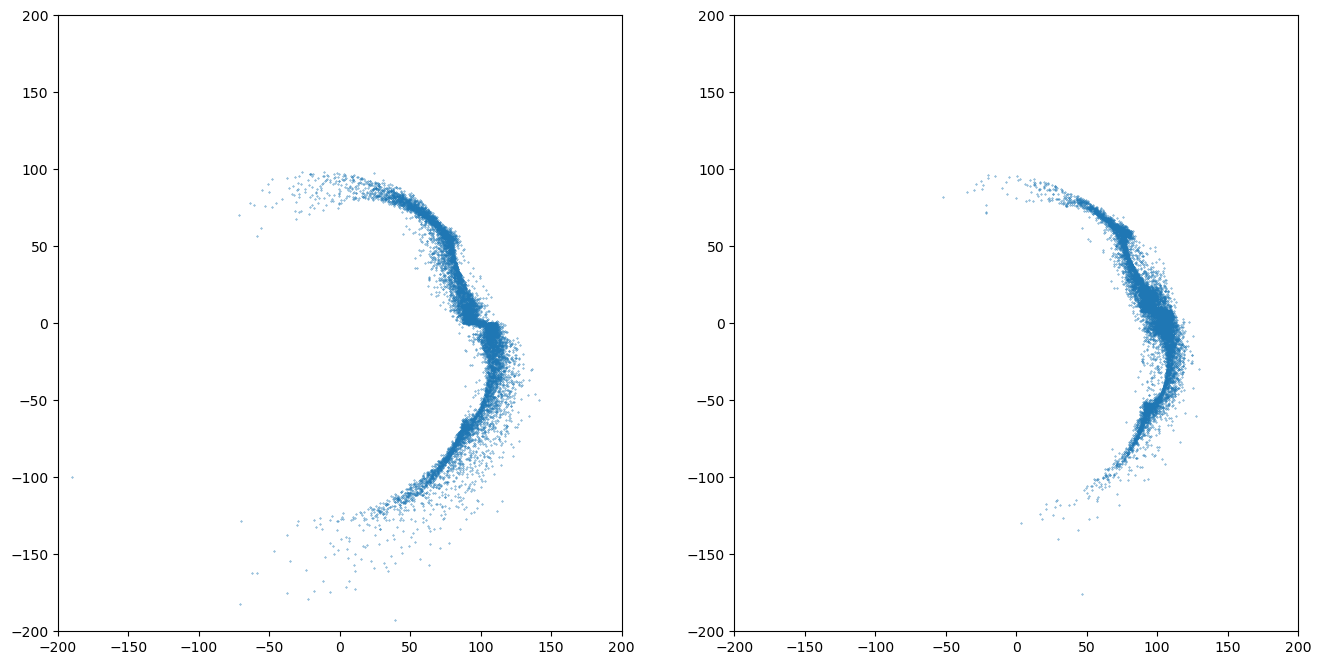

In [21]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.scatter(xv_stream_gala[:,0], xv_stream_gala[:,1], s=0.1)
# plt.axis('equal')
plt.xlim(-200, 200)
plt.ylim(-200, 200)

plt.subplot(1,2,2)
plt.scatter(xv_stream_spray[:, 0], xv_stream_spray[:, 1], s=0.1)
# plt.axis('equal')
plt.xlim(-200, 200)
plt.ylim(-200, 200)


In [16]:
from spray import *
from constants import *
tail = 0
seed = 111
logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha = params
vx0 *= GYR_TO_S/KPC_TO_KM
vy0 *= GYR_TO_S/KPC_TO_KM
vz0 *= GYR_TO_S/KPC_TO_KM

backward_trajectory = integrate_satellite(x0, y0, z0, vx0, vy0, vz0, logM, Rs, q, dirx, diry, dirz, -time)

forward_trajectory  = integrate_satellite(*backward_trajectory[-1, :], logM, Rs, q, dirx, diry, dirz, time*alpha)

theta_sat_forward = jnp.arctan2(forward_trajectory[:, 1], forward_trajectory[:, 0])
theta_sat_forward = jnp.where(theta_sat_forward < 0, theta_sat_forward + 2 * jnp.pi, theta_sat_forward)
theta_sat_forward = jax_unwrap(theta_sat_forward)

hessians  = jax.vmap(NFWHessian, in_axes=(0, 0, 0, None, None, None, None, None, None)) \
                    (forward_trajectory[:, 0], forward_trajectory[:, 1], forward_trajectory[:, 2], logM, Rs, q, dirx, diry, dirz)
@jax.jit
def get_rj_vj_R(hessians, orbit_sat, mass_sat):
    x, y, z, vx, vy, vz = orbit_sat.T

    # Compute angular momentum L
    Lx = y * vz - z * vy
    Ly = z * vx - x * vz
    Lz = x * vy - y * vx
    r = jnp.sqrt(x**2 + y**2 + z**2)  # Regularization to prevent NaN
    L = jnp.sqrt(Lx**2 + Ly**2 + Lz**2)

    # Rotation matrix (transform from host to satellite frame)
    R = jnp.stack([
        jnp.stack([x / r, y / r, z / r], axis=-1),
        jnp.stack([
            (y / r) * (Lz / L) - (z / r) * (Ly / L),
            (z / r) * (Lx / L) - (x / r) * (Lz / L),
            (x / r) * (Ly / L) - (y / r) * (Lx / L)
        ], axis=-1),
        jnp.stack([Lx / L, Ly / L, Lz / L], axis=-1),
    ], axis=-2)  # Shape: (N, 3, 3)

    # Compute second derivative of potential
    d2Phi_dr2 = (
        x**2 * hessians[:, 0, 0] + y**2 * hessians[:, 1, 1] + z**2 * hessians[:, 2, 2] +
        2 * x * y * hessians[:, 0, 1] + 2 * y * z * hessians[:, 1, 2] + 2 * z * x * hessians[:, 0, 2]
    ) / r**2 # 1 / Gyr²

    # Compute Jacobi radius and velocity offset
    Omega = L / r**2  # 1 / Gyr
    rj = ((mass_sat * G / (Omega**2 - d2Phi_dr2))) ** (1. / 3)  # kpc
    vj = Omega * rj

    return rj, vj, R
rj, vj, R = get_rj_vj_R(hessians, forward_trajectory, 10 ** logm)

ic_particle_spray = create_ic_particle_spray(forward_trajectory, rj, vj, R, tail, seed)
ic_particle_spray = jnp.array(np.load('ic_stream.npy'))

index = jnp.repeat(jnp.arange(0, N_STEPS, 1), N_PARTICLES // N_STEPS)
theta_stream , xv_stream = jax.vmap(integrate_stream_spray, in_axes=(0, 0, 0, 0, 0, 0, 0, None, None, None, None, None, None, None, None, None, None, None)) \
    (index, ic_particle_spray[:, 0], ic_particle_spray[:, 1], ic_particle_spray[:, 2], ic_particle_spray[:, 3], ic_particle_spray[:, 4], ic_particle_spray[:, 5],
    theta_sat_forward, forward_trajectory, logM, Rs, q, dirx, diry, dirz, logm, rs, time)

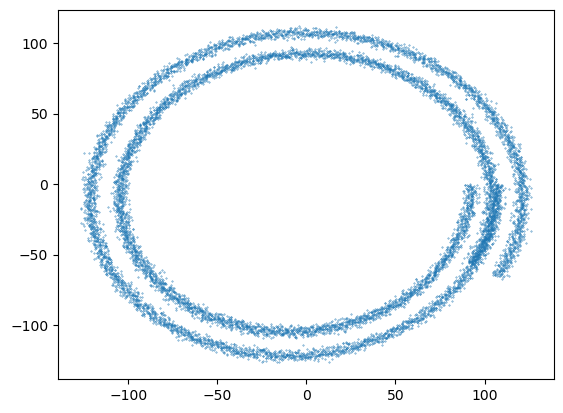

In [17]:
plt.scatter(ic_particle_spray[:, 0], ic_particle_spray[:, 1], s=0.1)

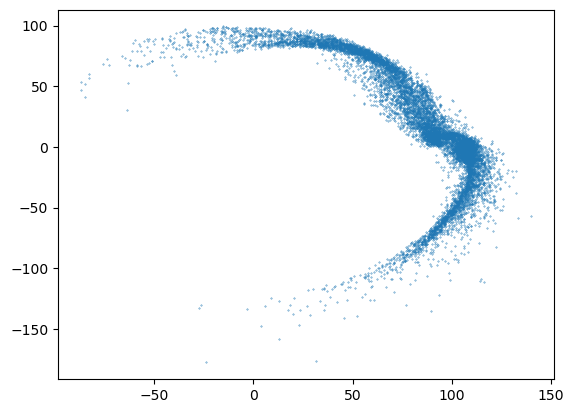

In [18]:
plt.scatter(xv_stream[:,0], xv_stream[:,1], s=0.1)